# Import/Setup

In [182]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [183]:
# import CADS dataset
filepath = r"C:\Users\marti\Documents\GitHub\481MidtermPaper\CADS.csv"
df = pd.read_csv(filepath)
#df.head()

,PUMFID,REFYEAR,REFMONTH,PROV,DVURBAN,MHHTYPEB,SEX,DV_AGEP,HHI_01,HDSIZE,...,ANY15DLF,IL6DL,IL5DL,DHAR12,ASSISTOD,DVSST1,DVSS1,CIG30,WEIGHTP,VERDATE
0,1000,2019,12,46,2,3,1,8,1,2,...,2,2,2,2,6,2,2,2,1256.4374,21DEC2020
1,1001,2019,9,46,2,6,1,5,1,4,...,2,2,2,2,6,3,3,2,1576.0206,21DEC2020
2,1002,2019,6,35,1,3,2,8,1,2,...,2,2,2,2,6,3,3,2,3880.9735,21DEC2020
3,1003,2019,8,11,1,3,1,8,1,3,...,1,1,2,2,6,1,1,1,212.8512,21DEC2020
4,1004,2019,6,12,1,3,1,9,1,3,...,1,1,1,6,6,2,2,2,1078.1501,21DEC2020


# Data Cleaning

In [184]:
# reduce df to columns of interest
sub_cols = ['SEX','PROV','DV_AGEP','DEM_05P','DEM_20','DEM_30','AB_15','INC_50','DVURBAN','HWB_10','HWB_05','ALC_20P','ALC_55','ALC_120A','AL_120BP',
            'ALC_90C','ALC_90D','ALC_90B','CAN_20A','CAN_45A','CAN_60','CAN_145','CAN_125A','C_125BP','CAN_80','CAN_15P','CAN_112C','CANALCEV',
            'ANY14DYR','TT_20','TT_25A','SS_05','SS_10','SS_25']

df = df[sub_cols]

# set up provincial controls
df['prov_BC'] = (df.loc[:,'PROV'] == 59).astype(int)
df['prov_AB'] = (df.loc[:,'PROV'] == 48).astype(int)
df['prov_SK'] = (df.loc[:,'PROV'] == 47).astype(int)
df['prov_MB'] = (df.loc[:,'PROV'] == 46).astype(int)
df['prov_ON'] = (df.loc[:,'PROV'] == 35).astype(int)
df['prov_QC'] = (df.loc[:,'PROV'] == 24).astype(int)
df['prov_NB'] = (df.loc[:,'PROV'] == 13).astype(int)
df['prov_NS'] = (df.loc[:,'PROV'] == 12).astype(int)
df['prov_PE'] = (df.loc[:,'PROV'] == 11).astype(int)
df['prov_NL'] = (df.loc[:,'PROV'] == 10).astype(int)

# sex controls
df['male'] = (df.loc[:,'SEX'] == 1).astype(int)

# age controls
df['age15_24'] = (df.loc[:,'DV_AGEP'] == any([1,2,3,4])).astype(int)
df['age25_34'] = (df.loc[:,'DV_AGEP'] == 5).astype(int)
df['age35_44'] = (df.loc[:,'DV_AGEP'] == 6).astype(int)
df['age45_54'] = (df.loc[:,'DV_AGEP'] == 7).astype(int)
df['age55_64'] = (df.loc[:,'DV_AGEP'] == 8).astype(int)
df['age65_plus'] = (df.loc[:,'DV_AGEP'] == 9).astype(int)

# rural/urban divide
df = df.loc[df['DVURBAN'] != 9] # drop observations where urban/rural is unstated (code 9)
df['urban'] = (df.loc[:,'DVURBAN'] == 1).astype(int)

# Indigenous identity
df['indigenous'] = (df.loc[:,'AB_15'] == 1).astype(int)

# Highest education
df['no_HS'] = (df.loc[:,'DEM_20'] == 1).astype(int)
df['HS'] = (df.loc[:,'DEM_20'] == 2).astype(int)
df['bel_BA'] = (df.loc[:,'DEM_20'] == any([3,4,5])).astype(int) # Post-secondary completed incl. trades, below Bachelor's
df['BA'] = (df.loc[:,'DEM_20'] == 6).astype(int) # Bachelor's degree
df['abv_BA'] = (df.loc[:,'DEM_20'] == 7).astype(int)
df = df.loc[df['DEM_20'] != 99]

# worked last week at job or business
df['worked'] = (df.loc[:,'DEM_30'] == 1).astype(int)

# Household income
df['inc_bel_20'] = (df.loc[:,'INC_50'] == 1).astype(int)
df['inc20_40'] = (df.loc[:,'INC_50'] == 2).astype(int)
df['inc40_60'] = (df.loc[:,'INC_50'] == 3).astype(int)
df['inc60_80'] = (df.loc[:,'INC_50'] == 4).astype(int)
df['inc80_100'] = (df.loc[:,'INC_50'] == 5).astype(int)
df['inc100_150'] = (df.loc[:,'INC_50'] == 6).astype(int)
df['inc_abv_150'] = (df.loc[:,'INC_50'] == 7).astype(int)

# lists of controls
c_income = ['inc_bel_20','inc20_40','inc40_60','inc60_80','inc80_100','inc100_150','inc_abv_150']
c_edu = ['no_HS','HS','bel_BA','BA','abv_BA']
c_age = ['age25_34','age35_44','age45_54','age55_64','age65_plus']
c_prov = ['prov_BC','prov_AB','prov_SK','prov_MB','prov_ON','prov_QC','prov_NB','prov_NS','prov_PE','prov_NL']

# add constant
df = sm.add_constant(df)

# The Rest

In [185]:
# 1. How do drinking/driving and weed/driving rates differ by urban/rural?

cols = []
for column in [c_income, c_age, c_edu, c_prov]:
    for cat in column:
        cols.append(cat)

cols.append('const')
cols.append('worked')
cols.append('indigenous')
cols.append('urban')
cols.append('ALC_120A')
cols.append('CAN_125A')

df2 = df[cols]
df2 = df2.rename(columns={'ALC_120A': 'drinkDriving', 'CAN_125A': 'weedDriving'})


df2_drink = df2.loc[(df2['drinkDriving'] == 1) | (df2['drinkDriving'] == 2)]
df2_cann = df2.loc[(df2['weedDriving'] == 1) | (df2['weedDriving'] == 2)]

df2_drink.loc[:,'drinkDriving'] = (df2.loc[:,'drinkDriving'] == 1).astype(int)
df2_cann.loc[:,'weedDriving'] = (df2.loc[:,'weedDriving'] == 1).astype(int)

C:\Users\marti\AppData\Local\Temp\ipykernel_33240\2838625578.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_drink.loc[:,'drinkDriving'] = (df2.loc[:,'drinkDriving'] == 1).astype(int)
C:\Users\marti\AppData\Local\Temp\ipykernel_33240\2838625578.py:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df2_drink.loc[:,'drinkDriving'] = (df2.loc[:,'drinkDriving'] == 1).astype(int)
C:\Users\marti\AppData\Local\Temp\ipykernel_33240\2838625578.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [186]:
# logit regression: drinkDriving ~ urban
logit = sm.Logit(df2_drink['drinkDriving'], df2_drink['urban']).fit()
#print(logit.summary())

# 2nd logit regression: drinkDriving ~ urban + education controls
exog = ['const','urban'] # set up regressors
for i in c_edu[1:]:
    exog.append(i)
      
logit2 = sm.Logit(df2_drink['drinkDriving'], df2_drink[exog]).fit()
#print(logit2.summary())

# 3rd logit regression: drinkDriving ~ urban + income controls
exog = ['const','urban'] # set up regressors
for i in c_income[1:]:
    exog.append(i)
      
logit3 = sm.Logit(df2_drink['drinkDriving'], df2_drink[exog]).fit()
#print(logit3.summary())

# 4th logit regression: drinkDriving ~ urban + provincial FE's
exog = ['const','urban'] # set up regressors
for i in c_prov[1:]:
    exog.append(i)
      
logit4 = sm.Logit(df2_drink['drinkDriving'], df2_drink[exog]).fit()

# 5th logit regression: drinkDriving ~ urban + all controls
exog = ['const','urban'] # set up regressors
for i in c_prov[1:]:
    exog.append(i)
for i in c_income[1:]:
    exog.append(i)
for i in c_edu[1:]:
    exog.append(i)
      
logit5 = sm.Logit(df2_drink['drinkDriving'], df2_drink[exog]).fit()
#print(logit5.summary())

Optimization terminated successfully.
         Current function value: 0.353197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.214909
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210812
         Iterations 8


In [187]:
#for col in exog:
#    print(col + ':' + str(sum(df2_drink[col])))

In [188]:
# logit regression: weedDriving ~ urban
clogit = sm.Logit(df2_cann['weedDriving'], df2_cann['urban']).fit()
#print(clogit.summary())

# 2nd logit regression: weedDriving ~ urban + controls
exog = ['const','urban'] # set up regressors
for i in c_edu[1:]:
    exog.append(i)
      
clogit2 = sm.Logit(df2_cann['weedDriving'], df2_cann[exog]).fit()
#print(clogit2.summary())

# 3rd logit regression: weedDriving ~ urban + income controls
exog = ['const','urban'] # set up regressors
for i in c_income[1:]:
    exog.append(i)
      
clogit3 = sm.Logit(df2_cann['weedDriving'], df2_cann[exog]).fit()
#print(clogit3.summary())

# 4th logit regression: weedDriving ~ urban + provincial FE's
exog = ['const','urban'] # set up regressors
for i in c_prov[1:]:
    exog.append(i)
      
clogit4 = sm.Logit(df2_cann['weedDriving'], df2_cann[exog]).fit()
#print(clogit4.summary())

# 5th logit regression: weedDriving ~ urban + all controls
exog = ['const','urban'] # set up regressors
for i in c_prov[1:]:
    exog.append(i)
for i in c_income[1:]:
    exog.append(i)
for i in c_edu[1:]:
    exog.append(i)
      
clogit5 = sm.Logit(df2_cann['weedDriving'], df2_cann[exog]).fit()
#print(logit5.summary())

Optimization terminated successfully.
         Current function value: 0.398822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.294391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292387
         Iterations 7


In [189]:
# Do Drink/driving and weed/driving admissions differ? By how much?  

# Visualize proportion of weed/drinking admissions, in aggregate & separated by province (hor. bar graph)

In [190]:
# group observations by province
# reset indices
df2_cann = df2_cann.reset_index(drop=True)
df2_drink = df2_drink.reset_index(drop=True)

for df in [df2_cann,df2_drink]:
    prov_data = []
    for i in range(0,len(df)):
        if df.loc[i,'prov_BC'].item() == 1:
            prov_data.append("BC")
        elif df.loc[i,'prov_AB'].item() == 1:
            prov_data.append("AB")
        elif df.loc[i,'prov_SK'].item() == 1:
            prov_data.append("SK")
        elif df.loc[i,'prov_MB'].item() == 1:
            prov_data.append("MB")
        elif df.loc[i,'prov_ON'].item() == 1:
            prov_data.append("ON")
        elif df.loc[i,'prov_QC'].item() == 1:
            prov_data.append("QC")
        elif df.loc[i,'prov_NB'].item() == 1:
            prov_data.append("NB")
        elif df.loc[i,'prov_NS'].item() == 1:
            prov_data.append("NS")
        elif df.loc[i,'prov_NL'].item() == 1:
            prov_data.append("NL")
        elif df.loc[i,'prov_PE'].item() == 1:
            prov_data.append("PE")
        else:
            prov_data.append("NA")
    df['province'] = prov_data

Text(0.5, 1.0, 'Self-reported rates of driving after consuming intoxicants, province and urban/rural segments')

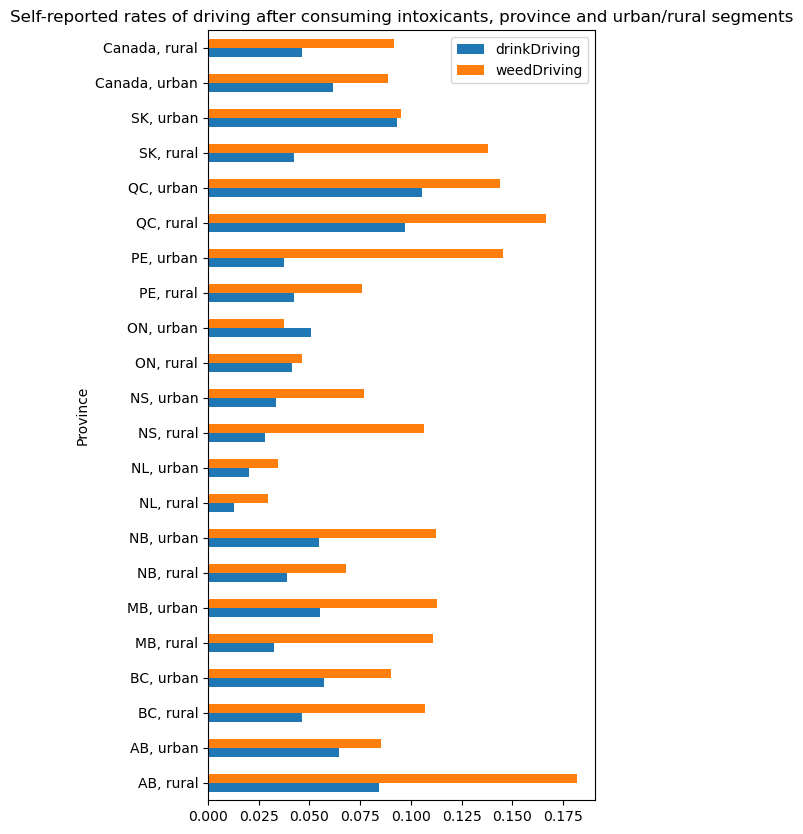

In [191]:
# take means for each province
drink_gb_prov = df2_drink[['province','urban','drinkDriving']].groupby(by=['province','urban'])
cann_gb_prov = df2_cann[['province','urban','weedDriving']].groupby(by=['province','urban'])


# load means into new object
bar_data = pd.merge(drink_gb_prov.mean(),cann_gb_prov.mean(), on=['province','urban'])

# Add aggregate measures 
aggs = pd.DataFrame([['Canada',1,df2_drink.loc[df2_drink['urban']==1,'drinkDriving'].mean(),df2_cann.loc[df2_cann['urban']==1,'weedDriving'].mean()],
        ['Canada',0,df2_drink.loc[df2_drink['urban']==0,'drinkDriving'].mean(),df2_cann.loc[df2_cann['urban']==0,'weedDriving'].mean()]], 
                    columns=['province','urban','drinkDriving','weedDriving'])


bar_data = pd.concat([bar_data.reset_index(), aggs],ignore_index=True)

# make bar chart
bar_data['urban'] = bar_data['urban'].astype('str')

labels = []
for i in range(0,len(bar_data)):
    text = bar_data.loc[i,'province'] + ', '
    if bar_data.loc[i,'urban'] == '1':
        text = text + 'urban'
    else:
        text = text + 'rural'
    labels.append(text)

bar_data['label'] = labels
bar_data = bar_data.set_index(['label'])

ax = bar_data.plot(kind='barh', figsize=(5, 10))
ax.set_ylabel('Province')
ax.set_title('Self-reported rates of driving after consuming intoxicants, province and urban/rural segments')

This bar chart plots the proportion, separated by province and urban/rural designation, of survey respondents who admit to either having two or more drinks or consuming cannabis within two hours before driving. There is notable provincial variation, with Saskatchewan, Alberta, and Quebec having proportions of survey respondents who drink (or consume cannabis) and drive above the national average. 

In every province-urban slice except for urban Ontario, consuming cannabis before driving is reported more frequently than drinking and driving. Except for New Brunswick,  Manitoba, Newfoundland and Prince Edward Island, the proportion of those consuming cannabis before driving is notably higher in rural areas than their urban counterparts. 

Cannabis consumption before driving is markedly higher in rural Alberta and Quebec than drinking and driving. Rural Albertans were 10 percentage points more likely to report they have consumed cannabis before driving than having two or more drinks. Rural Quebecois were 7 percentage points more likely to report consuming cannabis before driving as opposed to drinking. 


In [202]:
stargazer = Stargazer([logit,logit2,logit3,logit4,logit5,clogit,clogit2,clogit3,clogit4,clogit5])
stargazer.covariate_order(['urban','const'])
stargazer.add_line('Education controls',["","Yes","","","Yes","","Yes","","","Yes"])
stargazer.add_line('Income controls',["","","Yes","","Yes","","","Yes","","Yes"])
stargazer.add_line('Prov. Fixed Effects',["","","","Yes","Yes","","","","Yes","Yes"])
stargazer.add_custom_notes(['Regression type: Logit'])
stargazer.custom_columns(['Alcohol','Cannabis'],separators=[5,5])


from IPython.core.display import HTML
HTML(stargazer.render_html())

Appears to be simple correlation between rural areas and more incidence of drinking/driving amongst drinkers, a dangerous health and potentially illegal behaviour. Trend appears to reverse itself once education and income controls are added, suggesting that inequalities in income and education may be driving this risk-based behaviour?

As for cannabis and driving, same urban/rural correlation which goes to zero with education/income controls. But controls put urban/rural on level playing field whereas for drinking it switches to more proportionate in urban areas. 

For future areas of analysis, maybe look specifically at incidence vs income and incidence vs education - without the urban/rural split?
Also: Does education/income affect number of times you will drive under the influence?

Cannabis data: conditioned on consuming cannabis within last 12 months and driving within last 12 months
Alcohol data: conditioned on consuming alcohol within last 12 months, and driving within last 12 months

In [201]:
# Regression table for drink/cannabis, education controls, income controls
stargazer2 = Stargazer([logit2,logit3,clogit2,clogit3])
stargazer2.add_custom_notes(['Regression type: Logit'])
stargazer2.custom_columns(['Alcohol','Cannabis'],separators=[2,2])
stargazer2.covariate_order(['urban','HS','bel_BA','BA','abv_BA','inc20_40','inc40_60','inc60_80','inc80_100','inc100_150','inc_abv_150'])

HTML(stargazer2.render_html())

Notable coefficients for drinking/driving and both education and HH income. Controlling for urban/rural, higher income brackets have statistically significant higher probability of reporting drinking/driving compared to reference below 20K income category. This is in a universe where all income levels have drinken, and driven a vehicle. Maybe check sample size in each category? Maybe it is vehicle ownership; lower incomes less likely to afford a vehicle but perhaps have a job or have had other reason to drive, scenarios in which they are less likely to be drinking in the first place.

Notable negative correlation between higher education and drink/driving, with no HS as reference category; higher educated individuals seems to be less likely to drink/drive

In [ ]:
# IF TIME: Create barcharts showing differing distributions between frequency of drink/driving and cannabis/driving - in aggregate
# and urban/rural split